# Object Detection

본 핸즈온에선 COCO 데이터셋에서 사전 훈련된 모델을 파인튜닝하여 이미지에서 오토바이를 감지하는 모델을 AutoGluon으로 훈련합니다.
AutoGluon-Vision을 사용하면 단 몇 줄의 코드로 최적화된 모델을 쉽게 훈련할 수 있습니다.


In [1]:
import os
import autogluon.core as ag
from autogluon.vision import ObjectDetector

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.10.0` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


<br>

## 1. Data preparation and Training

이미지에서 오토바이를 감지하기 위한 toy 데이터셋을 수집합니다. 이 데이터셋은 23M에 불과하지만 VOC와 동일한 형식을 따르며, 훈련 이미지 120개, 검증 이미지 50개, 테스트 이미지 50개로 구성되어 있습니다.

### Data preparation

In [2]:
save_path = 'ag-03-object-detection'
!rm -rf $save_path

In [3]:
url = 'https://autogluon.s3.amazonaws.com/datasets/tiny_motorbike.zip'
train_dataset = ObjectDetector.Dataset.from_voc(url, splits='trainval')

21273KB [00:01, 19635.82KB/s]                           


tiny_motorbike/
├── Annotations/
├── ImageSets/
└── JPEGImages/


In [4]:
train_dataset.head(5)

,image,rois,image_attr
0,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.702, 'ymin':...","{'width': 500.0, 'height': 375.0}"
1,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.117117117117...","{'width': 333.0, 'height': 500.0}"
2,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'person', 'xmin': 0.102, 'ymin': 0....","{'width': 500.0, 'height': 432.0}"
3,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.226, 'ymin':...","{'width': 500.0, 'height': 375.0}"
4,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.357357357357...","{'width': 333.0, 'height': 500.0}"


### Training

아래 코드 셀을 실행하면, 두 번의 trial을 거치고 빠른 훈련을 위해 5 epoch만 훈련합니다. 하이퍼파라메터로 YOLOv3 기반 MobileNet과 ResNet 기반 SSD(Single Shot Multibox Detector) 모델을 선택적으로 사용하게 조정하였습니다. 실제 핸즈온에서는 설정을 간소화하였으므로 단일 모델만 훈련되지만, `num_trial`이나 `time_limit`을 조정하면 여러 모델들이 복합적으로 사용됩니다.

하이퍼파라메터 튜닝은 기본적으로 랜덤 검색(Random search)으로 설정되지만, `search_strategy = 'bayesopt'` 또는 `search_strategy = 'bayesopt_hyperband'` 옵션 또한 지원하고 있습니다.

In [5]:
ag.space.Categorical('yolo3_mobilenet1.0_coco', 'ssd_512_resnet50_v1_coco')

Categorical['yolo3_mobilenet1.0_coco', 'ssd_512_resnet50_v1_coco']

In [7]:
time_limit = 60*3
detector = ObjectDetector(path=save_path)
hyperparameters = {'epochs': 5, 'batch_size': 8,
                  'transfer': ag.space.Categorical('yolo3_mobilenet1.0_coco', 'ssd_512_resnet50_v1_coco')}
#hyperparamter_tune_kwargs = {'num_trials': 2}
detector.fit(train_dataset, time_limit=time_limit, 
             hyperparameters=hyperparameters)

In a future release ObjectDetector may be entirely reworked to use Torch as a backend.
This future change will likely be API breaking.Users should ensure they update their code that depends on ObjectDetector when upgrading to future AutoGluon releases.
For more information, refer to ObjectDetector refactor GitHub issue: https://github.com/awslabs/autogluon/issues/1559

The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Randomly split train_data into train[159]/validation[11] splits.
Starting fit without HPO
modified configs(<old> != <new>): {
root.gpus            (0, 1, 2, 3) != (0,)
root.valid.batch_size 16 != 8
root.train.early_stop_patience -1 != 10
root.train.seed      233 != 637
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    20 != 5
root.train.batch_size 16 != 8
root.train.early_stop_max_value 1.0 != inf
root.dataset         voc_tiny != auto
root.yolo3.base_network darknet53 != mobilenet1.0
root.yolo3.transfer  yolo3_d

88993KB [00:01, 58116.84KB/s]                           
Start training from [Epoch 0]
[10:33:37] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[10:34:42] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[Epoch 0] Training cost: 160.267, ObjLoss=11.687, BoxCenterLoss=8.274, BoxScaleLoss=3.264, ClassLoss=4.827
[10:34:51] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[Epoch 0] Validation: 
pottedplant=nan
boat=nan
chair=nan
bus=nan
person=0.8525339602925809
bicycle=1.00000000000

ConnectionResetError: [Errno 104] Connection reset by peer

Applying the state from the best checkpoint...


9624KB [00:00, 18861.47KB/s]                          
Finished, total runtime is 262.60 s
{ 'best_config': { 'batch_size': 8,
                   'dist_ip_addrs': None,
                   'early_stop_baseline': -inf,
                   'early_stop_max_value': inf,
                   'early_stop_patience': 10,
                   'epochs': 5,
                   'final_fit': False,
                   'gpus': [0],
                   'lr': 0.001,
                   'ngpus_per_trial': 8,
                   'nthreads_per_trial': 128,
                   'num_workers': 4,
                   'scheduler': 'local',
                   'seed': 637,
                   'time_limits': 180,
                   'transfer': 'yolo3_mobilenet1.0_coco'},
  'total_time': 183.42659974098206,
  'train_map': 0.7785695060773431,
  'valid_map': 0.7785695060773431}


<br>

## 2. Evaluation and Prediction

### Evaluation

In [8]:
detector.fit_summary()

{'train_map': 0.7785695060773431,
 'valid_map': 0.7785695060773431,
 'total_time': 183.42659974098206,
 'best_config': {'transfer': 'yolo3_mobilenet1.0_coco',
  'lr': 0.001,
  'epochs': 5,
  'nthreads_per_trial': 128,
  'ngpus_per_trial': 8,
  'time_limits': 180,
  'dist_ip_addrs': None,
  'scheduler': 'local',
  'batch_size': 8,
  'early_stop_patience': 10,
  'early_stop_baseline': -inf,
  'early_stop_max_value': inf,
  'num_workers': 4,
  'gpus': [0],
  'seed': 637,
  'final_fit': False},
 'fit_history': {'train_map': 0.7785695060773431,
  'valid_map': 0.7785695060773431,
  'total_time': 183.42659974098206,
  'best_config': {'transfer': 'yolo3_mobilenet1.0_coco',
   'lr': 0.001,
   'epochs': 5,
   'nthreads_per_trial': 128,
   'ngpus_per_trial': 8,
   'time_limits': 180,
   'dist_ip_addrs': None,
   'scheduler': 'local',
   'batch_size': 8,
   'early_stop_patience': 10,
   'early_stop_baseline': -inf,
   'early_stop_max_value': inf,
   'num_workers': 4,
   'gpus': [0],
   'seed': 637

In [9]:
test_dataset = ObjectDetector.Dataset.from_voc(url, splits='test')

test_map = detector.evaluate(test_dataset)
print("mAP on test dataset: {}".format(test_map[1][-1]))

tiny_motorbike/
├── Annotations/
├── ImageSets/
└── JPEGImages/
mAP on test dataset: 0.0


In [10]:
def plot_bbox(img_path, result, threshold=0.5):
    
    import numpy as np
    import random
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt
    from PIL import Image
    
    img = Image.open(img_path)    
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(img)
    w,h = img.size

    result = result[result['predict_score'] > threshold] 
    n_cls_preds = len(result)
    
    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    bbox_colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    random.seed(0)
    random.shuffle(bbox_colors)
    
    for i in range(n_cls_preds-1, -1, -1):
        bbox = result.iloc[i]['predict_rois']
        pred_cls = result.iloc[i]['predict_class']
        pred_score = result.iloc[i]['predict_score']
        label = '{} {:.2f}'.format(pred_cls, pred_score)
        color = bbox_colors[i]

        # Get box height and width
        x1 = bbox['xmin'] * w
        x2 = bbox['xmax'] * w
        y1 = bbox['ymin'] * h
        y2 = bbox['ymax'] * h

        # Get box height and width
        box_h = y2 - y1
        box_w = x2 - x1

        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)

        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                         bbox={'color': color, 'pad': 0})    

### Prediction

추론 결과는 표준적인 결과인 bounding box와 클래스 정보 및 score를 리턴하므로, 사용자 정의 함수나 GluonCV의 빌트인 함수로 쉽게 확인할 수 있습니다. 본 핸즈온에서는 사용자 정의 함수로 bounding box를 출력합니다.

   predict_class  predict_score  \
0      motorbike       0.789862   
1        bicycle       0.756643   
2         person       0.666951   
3      motorbike       0.134178   
4         person       0.054274   
5    pottedplant       0.041297   
6         person       0.033999   
7      motorbike       0.029379   
8    pottedplant       0.020827   
9    pottedplant       0.020315   
10        person       0.017874   
11     motorbike       0.013468   
12     motorbike       0.010641   
13   pottedplant       0.010372   

                                         predict_rois  
0   {'xmin': 0.3072948455810547, 'ymin': 0.4296552...  
1   {'xmin': 0.3072948455810547, 'ymin': 0.4296552...  
2   {'xmin': 0.38607802987098694, 'ymin': 0.240000...  
3   {'xmin': 0.38607802987098694, 'ymin': 0.240000...  
4   {'xmin': 0.7403494119644165, 'ymin': 0.3813147...  
5   {'xmin': 0.38607802987098694, 'ymin': 0.240000...  
6   {'xmin': 0.7653123140335083, 'ymin': 0.3666268...  
7   {'xmin': 0.00240549654

<Figure size 432x288 with 0 Axes>

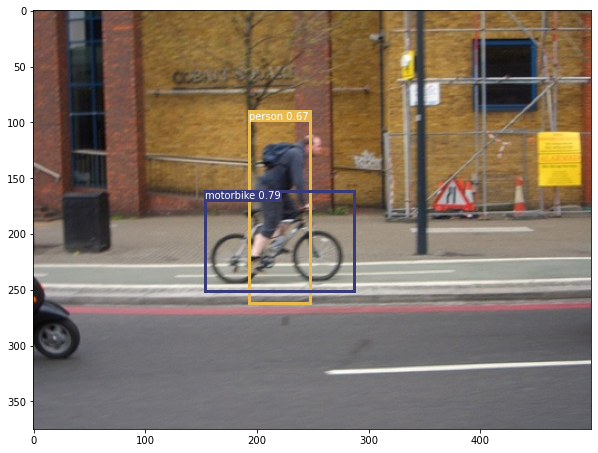

In [13]:
test_idx = 0
image_path = test_dataset.iloc[test_idx]['image']
result = detector.predict(image_path)
print(result)
plot_bbox(image_path, result)

### Save and load detectors

In [14]:
filename = os.path.join(save_path, 'detector.ag')
detector.save(filename)
detector_loaded = ObjectDetector.load(filename)
# use detector_loaded as usual
result = detector_loaded.predict(image_path)
print(result)

   predict_class  predict_score  \
0      motorbike       0.789862   
1        bicycle       0.756643   
2         person       0.666951   
3      motorbike       0.134178   
4         person       0.054274   
5    pottedplant       0.041297   
6         person       0.033999   
7      motorbike       0.029379   
8    pottedplant       0.020827   
9    pottedplant       0.020315   
10        person       0.017874   
11     motorbike       0.013468   
12     motorbike       0.010641   
13   pottedplant       0.010372   

                                         predict_rois  
0   {'xmin': 0.3072948455810547, 'ymin': 0.4296552...  
1   {'xmin': 0.3072948455810547, 'ymin': 0.4296552...  
2   {'xmin': 0.38607802987098694, 'ymin': 0.240000...  
3   {'xmin': 0.38607802987098694, 'ymin': 0.240000...  
4   {'xmin': 0.7403494119644165, 'ymin': 0.3813147...  
5   {'xmin': 0.38607802987098694, 'ymin': 0.240000...  
6   {'xmin': 0.7653123140335083, 'ymin': 0.3666268...  
7   {'xmin': 0.00240549654